In [6]:
!pip install nangs

# 2-dimensional laplace equation
# u_xx + u_yy = f(x,y)
# u(x,0) = g(x), u(x,b) = h(x)
# u(0,y) = p(y), u(a,y) = q(y)

import numpy as np
import matplotlib.pyplot as plt
import nangs
import torch

from nangs import *

device = "cuda" if torch.cuda.is_available() else "cpu"

class Laplace(PDE):
    def computePDELoss(self, inputs, outputs):
        
        x, y=inputs[:,0], inputs[:,1]
        u = outputs[:,0]
        
        #compute gradients
        grads=self.computeGrads(outputs, inputs)
        
        #compute loss
        u_x, u_y=grads[:, 0], grads[:, 1]
        
        grads2=self.computeGrads(u_x, inputs)
        u_xx=grads2[:, 0]
        
        grads2=self.computeGrads(u_y, inputs)
        u_yy=grads2[:, 1]
        
        # f = 0
        return {'pde': u_xx + u_yy}
    
pde=Laplace(inputs=('x', 'y'), outputs='u')

In [7]:
# g = 0, p = q = 0
# a = b = 1

x = np.linspace(0,1,20)
y = np.linspace(0,1,20)

mesh = Mesh({'x': x, 'y': y}, device=device)
pde.set_mesh(mesh)

In [8]:
# boundary conditions

x0 = np.array([0., 1.])
y0 = np.array([0.])
y1 = np.array([1.])

_x, _y = np.meshgrid(x0, y)
u1 = _x*_y*0
boco_x=Dirichlet({'x': x0, 'y': y}, {'u': u1.reshape(-1)}, device=device, 
                 name='boco_x')
pde.add_boco(boco_x)

_x, _y = np.meshgrid(x, y0)
u1 = _x*_y*0
boco_y=Dirichlet({'x': x, 'y': y0}, {'u': u1.reshape(-1)}, device=device, 
                 name='boco_y0')
pde.add_boco(boco_y)

_x, _y = np.meshgrid(x, y1)
u1 = np.sin(np.pi*_x)*(np.exp(np.pi)-np.exp(-1*np.pi))
boco_y=Dirichlet({'x': x, 'y': y1}, {'u': u1.reshape(-1)}, device=device, 
                 name='boco_y1')
pde.add_boco(boco_y)

In [14]:
BATCH_SIZE = 32
LR = 1e-4
EPOCHS = 3000
NUM_LAYERS = 8
NUM_HIDDEN = 512

mlp = MLP(len(pde.inputs), len(pde.outputs), NUM_LAYERS, NUM_HIDDEN).to(device)
optimizer = torch.optim.Adam(mlp.parameters())
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=LR, 
                                                pct_start=0.1, total_steps=EPOCHS)

pde.compile(mlp, optimizer, scheduler)
%time hist = pde.solve(EPOCHS, BATCH_SIZE)

CPU times: user 29min 3s, sys: 45.9 s, total: 29min 49s
Wall time: 32min 50s


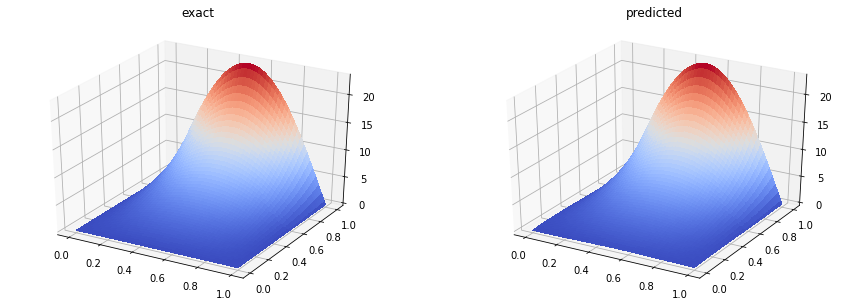

L2 error:  0.4036417615517673 %


In [15]:
# evaluate
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

x = np.linspace(0,1,100)
y = np.linspace(0,1,100)

eval_mesh=Mesh({'x': x,'y': y}, device=device)

u=pde.eval(eval_mesh)
u=u.cpu().numpy()
    
_x, _y=np.meshgrid(x,y)
u0=np.sin(np.pi*_x)*(np.exp(np.pi*_y)-np.exp(-np.pi*_y))

fig=plt.figure(figsize=(15, 5))
ax1=fig.add_subplot(1,2,1,projection='3d')
ax2=fig.add_subplot(1,2,2,projection='3d')
ax1.plot_surface(_x, _y, u0.reshape((len(_y),len(_x))), cmap=cm.coolwarm, 
                 linewidth=0, antialiased=False)
ax1.title.set_text('exact')
ax2.plot_surface(_x, _y, u.reshape((len(_y),len(_x))), cmap=cm.coolwarm, 
                 linewidth=0, antialiased=False)
ax2.title.set_text('predicted')
plt.show()
print("L2 error: ", np.sqrt(sum((u0.ravel()-u.ravel())**2))
      /np.sqrt(sum(u0.ravel()**2))*100,"%")